In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
import requests

class EMA_Strat:
    def __init__(self, df: pd.DataFrame, short_window: int, long_window: int):
        self.df = df.copy()
        self.short_window = short_window
        self.long_window = long_window
        
        # Convert Unix milliseconds to datetime
        self.df['time'] = pd.to_datetime(self.df['time'], unit='ms')
        self.df.set_index('time', inplace=True)
        self.df.sort_index(inplace=True)

    def calculate_signals(self) -> pd.DataFrame:
        # Calculate EMAs
        self.df['EMA_short'] = self.df['close'].ewm(span=self.short_window, adjust=False).mean()
        self.df['EMA_long'] = self.df['close'].ewm(span=self.long_window, adjust=False).mean()
        
        # Generate buy/sell signals
        self.df['signal'] = np.where(self.df['EMA_short'] > self.df['EMA_long'], 1, 0)
        self.df['position'] = self.df['signal'].diff()
        
        # Calculate returns
        self.df['returns'] = self.df['close'].pct_change()
        self.df['strategy_returns'] = self.df['signal'].shift(1) * self.df['returns']
        
        # Calculate cumulative returns
        self.df['cumulative_market_returns'] = (1 + self.df['returns']).cumprod() - 1
        self.df['cumulative_strategy_returns'] = (1 + self.df['strategy_returns']).cumprod() - 1
        
        # Remove any rows with NaN values
        self.df.dropna(inplace=True)
        
        return self.df
    
    def plot_signals(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16), sharex=True)
        
        # Plot prices and EMAs
        ax1.plot(self.df.index, self.df['close'], label='Close Price')
        ax1.plot(self.df.index, self.df['EMA_short'], label=f'EMA {self.short_window}')
        ax1.plot(self.df.index, self.df['EMA_long'], label=f'EMA {self.long_window}')
        
        # Plot buy/sell signals
        ax1.plot(self.df[self.df['position'] == 1].index, 
                 self.df['close'][self.df['position'] == 1],
                 '^', markersize=10, color='g', label='Buy Signal')
        ax1.plot(self.df[self.df['position'] == -1].index, 
                 self.df['close'][self.df['position'] == -1],
                 'v', markersize=10, color='r', label='Sell Signal')
        
        ax1.set_title('EMA Crossover Strategy')
        ax1.set_ylabel('Price')
        ax1.legend()
        
        # Plot cumulative returns
        ax2.plot(self.df.index, self.df['cumulative_market_returns'], label='Market Returns')
        ax2.plot(self.df.index, self.df['cumulative_strategy_returns'], label='Strategy Returns')
        ax2.set_title('Cumulative Returns')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Cumulative Returns')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    def backtest(self) -> Tuple[float, float, float, float, float]:
        # Total return
        total_return = self.df['cumulative_strategy_returns'].iloc[-1]
        
        # Annualized return
        days = (self.df.index[-1] - self.df.index[0]).total_seconds() / (24 * 60 * 60)
        if days > 1:  # Only calculate if we have more than a day of data
            annualized_return = (1 + total_return) ** (365.25 / days) - 1
        else:
            annualized_return = total_return  # For very short periods, just return total return
        
        # Max drawdown
        cumulative_max = (1 + self.df['cumulative_strategy_returns']).cummax()
        drawdown = (1 + self.df['cumulative_strategy_returns']) / cumulative_max - 1
        max_drawdown = drawdown.min()
        
        # Sharpe ratio (assuming risk-free rate of 0)
        if self.df['strategy_returns'].std() != 0:
            sharpe_ratio = np.sqrt(252) * self.df['strategy_returns'].mean() / self.df['strategy_returns'].std()
        else:
            sharpe_ratio = 0
        
        # Win rate
        trades = self.df[self.df['position'] != 0]
        if len(trades) > 0:
            win_rate = (trades['strategy_returns'] > 0).sum() / len(trades)
        else:
            win_rate = 0
        
        return total_return, annualized_return, max_drawdown, sharpe_ratio, win_rate

    def run_strategy(self) -> Tuple[pd.DataFrame, Tuple[float, float, float, float, float]]:
        self.calculate_signals()
        self.plot_signals()
        backtest_results = self.backtest()
        return self.df, backtest_results

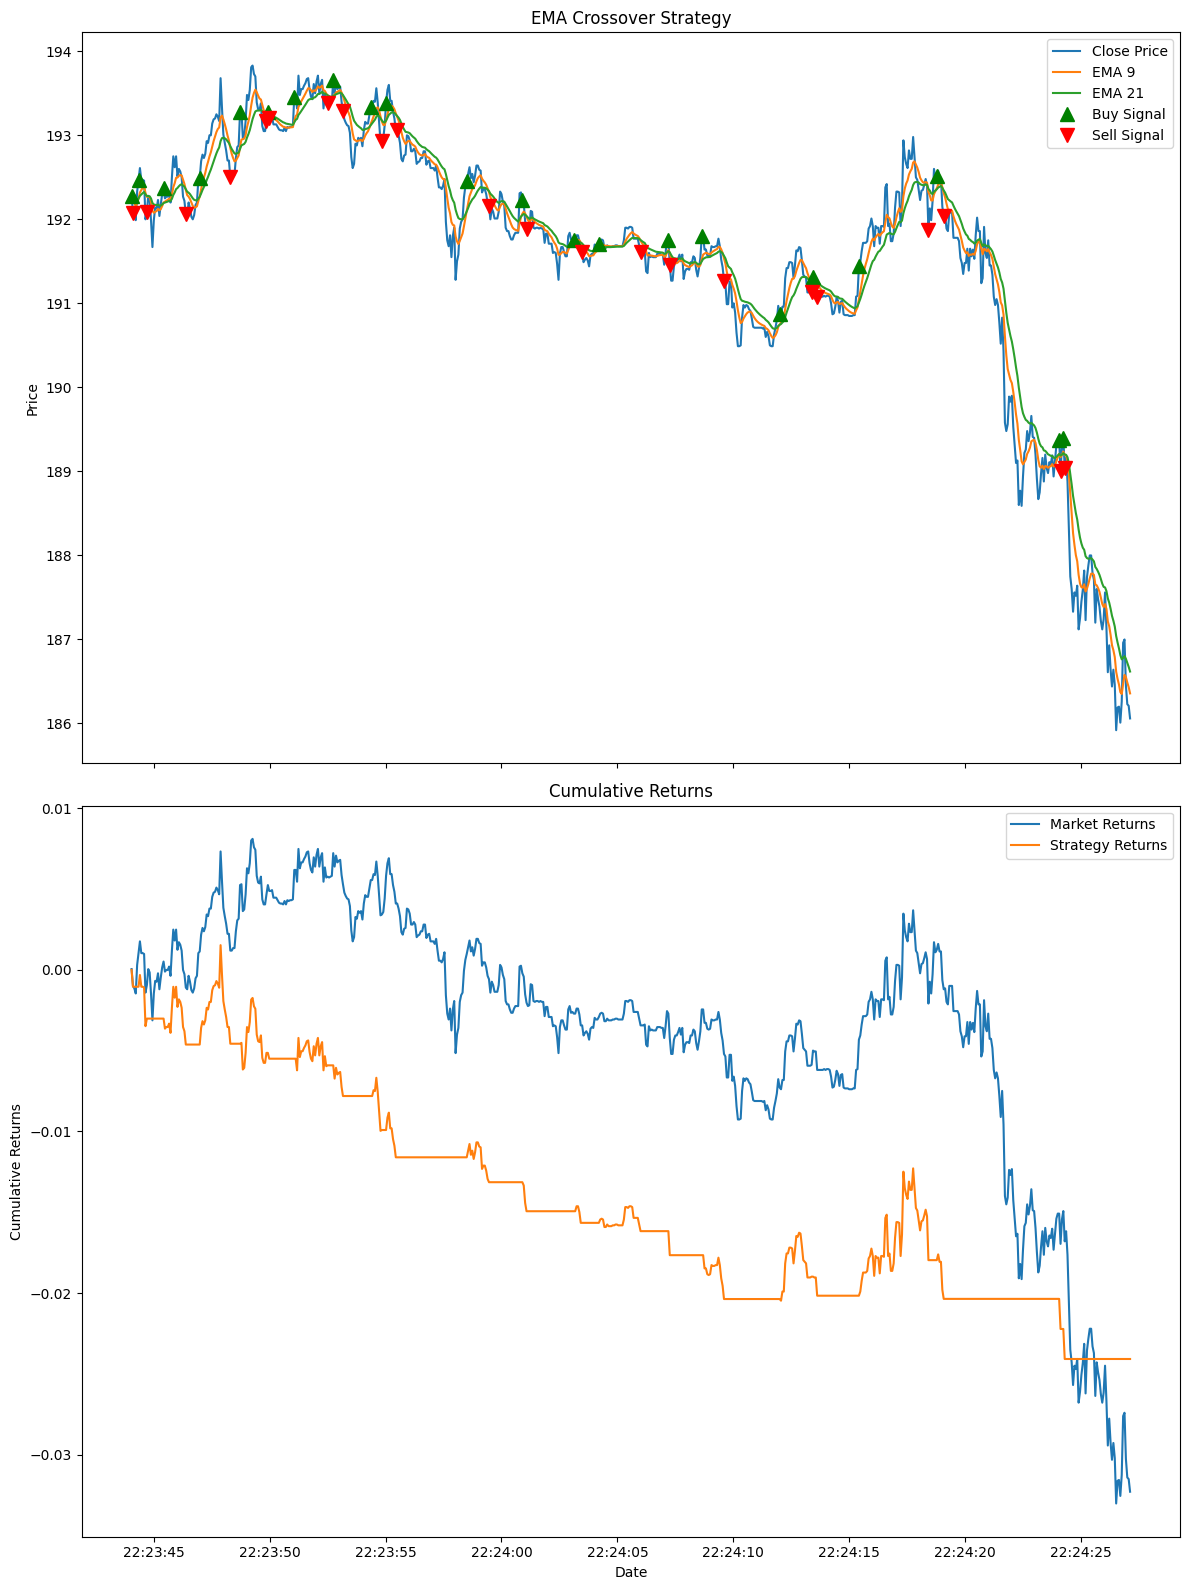

Total Return: -2.41%
Annualized Return: -2.41%
Max Drawdown: -2.56%
Sharpe Ratio: -1.09
Win Rate: 11.36%


In [27]:
# get data for the last 720 candles from kraken api
url = "https://api.kraken.com/0/public/OHLC"
querystring = {"pair":"SOLUSD","interval":"1"}
headers = {
  'Accept': 'application/json'
}
response = requests.request("GET", url, params=querystring)

# parse the json response and create a dataframe
data = response.json()
df = pd.DataFrame(data['result']['SOLUSD'], columns=['time', 'open', 'high', 'low', 'close', 'vwap', 'volume', 'count'])

#besides time and count are strings so we need to convert them to floats
df['close'] = df['close'].astype(float)
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['vwap'] = df['vwap'].astype(float)
df['volume'] = df['volume'].astype(float)

# ---- Run the strategy --- #
# Assuming df has 'close', 'volume', and 'time' columns, with 'time' in Unix milliseconds
ema_strategy = EMA_Strat(df, short_window=9, long_window=21)
result_df, (total_return, annualized_return, max_drawdown, sharpe_ratio, win_rate) = ema_strategy.run_strategy()

# Print results
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Win Rate: {win_rate:.2%}")